In [ ]:
import os
import sys

__file__ = os.path.abspath('4.zadanie_V1.ipynb')
baseName = os.path.basename(__file__)
dirName = os.path.dirname(__file__)
sys.path.append(dirName + r'/..')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from modules.Z4.z4 import * 


Lokalita - Bratislava\
Podlozie - C\
Spektrum - 2

In [ ]:
FI = 300  # mm
TW = 10  # mm
H = 50  # m
M = 1000  # kg
q = 1.5
ag = 0.63
tvary = 3
hmoty = 4

In [ ]:
delta51 = 2069293.9
delta52 = 1309487.1
delta53 = 646673.5
delta54 = 177846.7

delta41 = 1309487.1
delta42 = 873017.0
delta43 = 452686.8
delta44 = 129350.1

delta31 = 646673.5
delta32 = 452686.8
delta33 = 258700.1
delta34 = 80853.3

delta21 = 177846.7
delta22 = 129350.1
delta23 = 80853.3
delta24 = 32356.7

In [ ]:
mm = matica_hmotnosti(M)

In [ ]:
delta = np.array([
    [delta51, delta52, delta53, delta54],
    [delta41, delta42, delta43, delta44],
    [delta31, delta32, delta33, delta34],
    [delta21, delta22, delta23, delta24]])*10**-6
delta

array([[2.0692939, 1.3094871, 0.6466735, 0.1778467],
       [1.3094871, 0.873017 , 0.4526868, 0.1293501],
       [0.6466735, 0.4526868, 0.2587001, 0.0808533],
       [0.1778467, 0.1293501, 0.0808533, 0.0323567]])

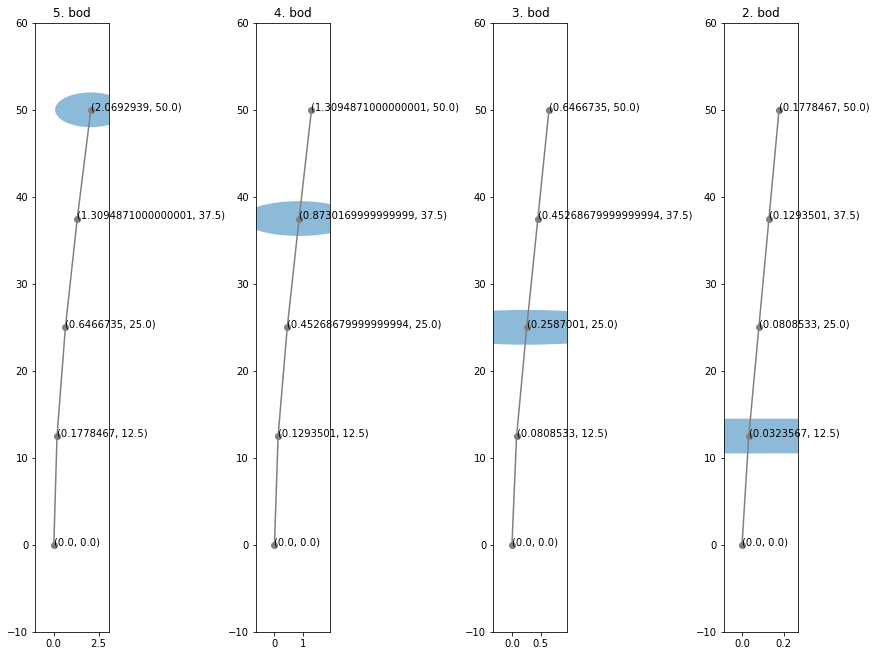

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, constrained_layout=True, figsize=(12, 9))

i = 0
for ax in axs.flat:
    i += 1
    plotSchema(delta, H_vector(H), hmoty, ax, i-1)

Z jednotkovej sily pôsobiacej vo vyznačenom bode dostaneme deformácie delta

In [ ]:
f, omega = frekvencie(delta_inv(delta), mm)

frekvencia 1. tvaru: 0.090 Hz 
 frekvencia 2. tvaru: 0.578 Hz 
 frekvencia 3. tvaru: 1.632 Hz


In [ ]:
T = periody(f)
# 0.071	14.109
# 0.436	2.295
# 1.200	0.833


perioda 1. tvaru: 11.143 s 
 perioda 2. tvaru: 1.730 s 
 perioda 3. tvaru: 0.613 s


In [ ]:
def vlastne_tvary(tvary, hmoty, mm, omega, delta):
    V0 = []
    for i in range(tvary):
        vlTvar = vlastny_tvar(hmoty, tvary, mm, omega, delta_inv(delta), i)
        V0.append(vlTvar)
    V0 = np.array(V0)
    return V0

In [ ]:
V0 = vlastne_tvary(tvary, hmoty, mm, omega, delta)

1. vlastny tvar V0 = [25.52564116 16.51431109  8.37491915  2.36218158]
2. vlastny tvar V0 = [ 15.93619248 -11.92440528 -21.93181636 -11.08340016]
3. vlastny tvar V0 = [  9.02466351 -20.54634389   7.04733858  21.13618273]


### Navrhove spektrum

In [ ]:
def spektrum(ag, q, periody):
    Sd = []
    for perioda in periody:
        Sd.append(sd(spektrum_parametre_2("C"), perioda, ag, q))
    print(f'Sd = {Sd}')
    return Sd

In [ ]:
Sd = spektrum(ag, q, T)

Sd = [0.126, 0.15789963661724304, 0.6425702765256349]


### Metóda náhradných seizmických síl

In [ ]:
Fb_ = Fb(hmoty_total(M, hmoty), Sd[0], lambda_=1)

Fb = 504.0 kN


Sily

In [ ]:
F = seizmicke_sily(V0, M, Fb_, hmoty)

F [kN] = [157.36093762927266, 76.5083972788801, 31.68736038838426, 7.8716159448561225]


In [ ]:
HV = np.delete(H_vector(H), -1).reshape(4,1) # remove 0 height and reshape to 4x1 matrix
F = np.array(F).reshape((4, 1)) 

Výsledné momenty

In [ ]:
mom = moment_FxR(F, HV)

Momenty [kNm]
 [[7868.04688146]
 [2869.06489796]
 [ 792.18400971]
 [  98.39519931]]


### Viactvarový výpočet

In [ ]:
gama_ = gama(V0, mm)

Sucinitel participacie gama 
 [[ 52.77705298]
 [-29.00342931]
 [ 16.66184093]]


In [ ]:
def zrychlenie_tot(hmoty, tvary, Sd, V0):
    stlpce = []
    for j in range(tvary):
        riadky = []
        stlpce.append(riadky)
    
        for i in range(hmoty):
            riadky.append(zrychlenie_i(Sd, gama_, V0, riadky=i, stlpce=j))
    A = np.array(stlpce)
    print(f'zrychlenia \n {A}')
    return A

In [ ]:
FF = sily_zrychlenia(zrychlenie_tot(hmoty, tvary, Sd, V0), M)

zrychlenia 
 [[ 169.7431826   109.81866058   55.69244749   15.70829179]
 [ -72.98188031   54.60937548  100.43962497   50.75788237]
 [  96.6216911  -219.97745289   75.45165203  226.29250566]]
Vysledne sily 
 [[ 169.7431826   109.81866058   55.69244749   15.70829179]
 [ -72.98188031   54.60937548  100.43962497   50.75788237]
 [  96.6216911  -219.97745289   75.45165203  226.29250566]]


In [ ]:
def moment_tot(hmoty, tvary, Sd, gama_, V0, HV):
    stlpce = []
    for j in range(tvary):
        riadky = []
        stlpce.append(riadky)
        for i in range(hmoty):
            riadky.append(moment(Sd, gama_, V0, HV, riadky=i, stlpce=j))
    momenty = np.array(stlpce)
    print(f'momenty \n {momenty}')
    return momenty
    

In [ ]:
MM = moment_tot(hmoty, tvary, Sd, gama_, V0, HV)

momenty 
 [[ 8487.1591302   5490.93302878  2784.62237458   785.41458929]
 [-2736.82051154  2047.85158036  3766.48593623  1903.42058891]
 [ 2415.54227761 -5499.43632227  1886.29130077  5657.3126414 ]]
